In [1]:
import sys, os, glob
import numpy as np
import scipy as sp
from typing import List, Tuple, Callable, Any, Dict
import matplotlib.pyplot as plt

# from methods.PolyCG.polycg.SO3 import so3
# from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
# from methods.free_energy import nucleosome_free_energy

np.set_printoptions(linewidth=250,precision=5,suppress=True)

### Methods

In [2]:
def read_sequences(fn: str): 
    seqs = []
    with open(fn, "r") as f:
        for line in f.readlines():
            if len(line.strip()) > 0:
                seqs.append(line.strip())
    return seqs

def histogram(data,density=True):
    bins = np.arange(np.min(data),np.max(data)+2)-0.5
    hist, edges = np.histogram(data,bins=bins,density=density)
    vals = 0.5*(edges[1:]+edges[:-1])
    return np.array((vals,hist)).T

def find_overlap(allseqs):
    if len(allseqs) < 2:
        return 0
    # find overlap
    noverlap = 0
    for o in range(1,len(allseqs[0])):
        match = True
        for i in range(o):
            if allseqs[0][-o+i] != allseqs[1][i]:
                match = False
                break
        if match:
            noverlap = o     
    return noverlap

def read_path_hist(path):
    outs = sorted(glob.glob(path + '/*.npy'))
    sums = np.zeros(np.load(outs[0]).shape)
    for out in outs:
        vals = np.load(out)
        sums += vals
    return vals

def match_hists(hists,noverlap):
    if len(hists) == 1:
        return np.copy(hists[0])
    hists = [np.copy(hist) for hist in hists]
    ntot = len(hists[0]) + np.sum([len(hist)-noverlap for hist in hists[1:]])
    thist = np.zeros(ntot)
    thist[:len(hists[0])] = hists[0]
    curr_last = len(hists[0])-noverlap
    for i in range(1,len(hists)):
        fac = np.sum(hists[i-1][-noverlap:])/np.sum(hists[i][:noverlap])
        # fac = np.sum(hists[i-1][-noverlap:-2])/np.sum(hists[i][:noverlap-2])
        # fac = 1
        hists[i] *= fac
        thist[curr_last:curr_last+len(hists[i])] = hists[i]
        curr_last = curr_last+len(hists[i]) - noverlap
        print(fac)
    return thist
        

### Construct energy

In [3]:
mainname = 'Data/601_450/601_450'

seqsfns = sorted(glob.glob(mainname+'_split*.seqs'))
nums = sorted([int(fn.split('_split')[-1].split('.')[0].split('_')[0]) for fn in seqsfns])

nums = nums[2:]

# n = 1
# nums = nums[n:n+1]

allseqs = [read_sequences(mainname+f'_split{num}.seqs') for num in nums]
noverlap = find_overlap(allseqs)

# read all hists
hists = []
theories = []
for num in nums:
    path = mainname + f'_split{num}'
    hist = read_path_hist(path)
    
    # rescale 
    tfe = np.load(path+'_fe.npy')[:,0]
    tfes = tfe - np.max(tfe)
    hist *= np.exp(-tfes)
    
    theories.append(tfe)
    hists.append(hist)
    
     
thist = match_hists(hists,noverlap)

ttheo = np.zeros(thist.shape)
cid = 0
for theo in theories:
    ttheo[cid:cid+len(theo)] = theo
    cid += len(theo)-noverlap

# print(thist)
sampledfe = -np.log(thist/np.sum(thist))

2.242363729716544
5.4494834773046765
3.006826792370337
5.655887558973095
48.670637142540066
171.2591806789535
928.8775553745566
175.2962688384236
0.4691843685538553
1.352151459722739
5.154471401696183
0.41281921395569454
0.097400144332386
0.026180921054959973
0.0052912198516063035


### Plot free energy

25
53
81
109
137
165
193
221
249
277
305
333
361
389
417
445
473


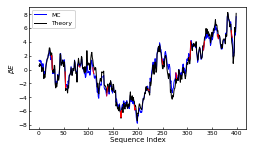

In [6]:
# theory_fn = mainname + '_fe.npy'
# theoryfe = np.load(theory_fn)
# print(theoryfe.shape)

savefn = 'Figs/' + os.path.basename(mainname)
highlight_overlap = False


fig = plt.figure(figsize=(8.6/2.54,5./2.54))
ax1 = fig.add_subplot(111)
 

sfeshift = sampledfe - np.mean(sampledfe)
theoryshift = ttheo - np.mean(ttheo)

# sfeshift = sampledfe - sampledfe[0]
# theoryshift = ttheo - ttheo[0]


Epos   = np.arange(len(sfeshift))
ax1.plot(Epos,sfeshift,lw=1,color='blue',zorder=2,label='MC')

ax1.plot(np.arange(len(theoryshift)),theoryshift,lw=1,color='black',zorder=2,label='Theory')

if highlight_overlap:
    for i in range(17):
        lens = len(hists[0])
        id = lens-noverlap + i*(lens)
        print(id)
        ax1.plot(Epos[id:id+noverlap],sfeshift[id:id+noverlap],lw=1,color='red',zorder=2)

tick_pad            = 2
axlinewidth         = 0.9
axtick_major_width  = 0.6
axtick_major_length = 1.6
tick_labelsize      = 6
label_fontsize      = 7

ax1.legend(fontsize=6)

ax1.set_xlabel('Sequence Index',size = label_fontsize,labelpad=1)
ax1.set_ylabel(r'$\beta E$',size = label_fontsize,labelpad=1)

ax1.tick_params(axis="both",which='major',direction="in",width=axtick_major_width,length=axtick_major_length,labelsize=tick_labelsize,pad=tick_pad)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.7)
    
plt.subplots_adjust(
    left=0.09,
    right=0.98,
    bottom=0.12,
    top=0.98,
    wspace=0.2,
    hspace=0.26)


plt.savefig(savefn + '.png',dpi=300,facecolor='white')
plt.show()

### plot splits

NameError: name 'rescaled_sampledfe' is not defined

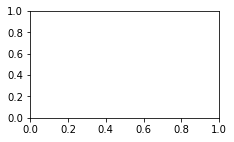

In [5]:
mainname = 'Data/601_450/601_450'
seqsfns = sorted(glob.glob(mainname+'_split*.seqs'))

for seqsfn in seqsfns:
    basename = os.path.splitext(seqsfn)[0]
    hist = read_path_hist(basename)
    sfe = -np.log(thist/np.sum(thist))
    tfe = np.load(basename+'_fe.npy')
    
    
    savefn = 'Figs/' + basename

    fig = plt.figure(figsize=(8.6/2.54,5./2.54))
    ax1 = fig.add_subplot(111)
    

    sfeshift = rescaled_sampledfe - rescaled_sampledfe[0]

    Epos   = np.arange(len(sfeshift))
    ax1.plot(Epos,sfeshift,lw=1,color='blue',zorder=2)

    theory = theoryfe[:,0]
    theory = theoryfe[:len(sampledfe),0]

    theoryshift = theory-theory[0]

    ax1.plot(np.arange(len(theoryshift)),theoryshift,lw=1,color='black',zorder=2)



    tick_pad            = 2
    axlinewidth         = 0.9
    axtick_major_width  = 0.6
    axtick_major_length = 1.6
    tick_labelsize      = 6
    label_fontsize      = 7

    ax1.set_xlabel('Nucleosome Position',size = label_fontsize,labelpad=1)
    ax1.set_ylabel(r'$\beta E$',size = label_fontsize,labelpad=1)

    ax1.tick_params(axis="both",which='major',direction="in",width=axtick_major_width,length=axtick_major_length,labelsize=tick_labelsize,pad=tick_pad)

    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(0.7)
        
    plt.subplots_adjust(
        left=0.09,
        right=0.98,
        bottom=0.06,
        top=0.98,
        wspace=0.2,
        hspace=0.26)


    plt.savefig(savefn + '.png',dpi=300,facecolor='white')
    plt.show()  
    